## Take a bunch of runs and re-do them with 

In [ ]:
for i in data_dict:
    if type(data_dict[i]) != dict:
        print(f"top layer: {i} {data_dict[i]}")
    print("_____ contents one level below_____")
    for j in data_dict[i]:
        try:
            
            print(f"\t\tpath: {i} {j} value: {data_dict[i][j]}")
        except:
            pass
            print("_____ contents two levels below_____")
            for jj in data_dict[i][j]:
                try:
                    print(f"\t\t\t\t path: {i} {j} {jj} value: {data_dict[i][j][jj]}")
                except:
                    pass

In [1]:
from matplotlib import rc
import numpy as np
from netCDF4 import Dataset

import matplotlib.pyplot as plt
import os
import xarray as xr
import subprocess
import matplotlib.pyplot as plt
import shutil
os.chdir("/home/149/ab8992/bottom_near_inertial_waves/automate_experiments")

import autolib as al
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 112.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46019,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 112.00 GiB
Comm: tcp://127.0.0.1:39697,Total threads: 4
Dashboard: /proxy/38741/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:37329,


# Notebook to re-run our experiments in June. 

Want to create a master notebook that generates all of the common forcings, and the perterbation values for each experiment. Write a function that takes common & perterbation fields

| Experiment | Common | Perterbed|
| --- |---|--- |
| Topo Height | windstress | topog |
| Topo Width | Windstress | topog  |
| Forcing Width | topog | Windstress  |
| Strat | Windstress | topog|
| Duration | topog | Windstress |
| Strength | topog | Windstress |

Experiment name format:

| Type | Format |
|---|---|
| experiments | `june_perterb_hill_nlayer` |
|common topog  | `june_common_hill_nlayer`  |
|common wind | `june_common_wind_nlayer`  |


In [2]:
## Iterate over topog type and nlayers
from importlib import reload
reload(al)

def set_si_coords(array):
    return array.assign_coords({"time":("time",array.time.values * 60),
                             "xq":("xq",array.xq.values * 1000),
                             "xh":("xh",array.xh.values * 1000),
                             "yh":("yh",array.yh.values * 1000),
                             "yq":("yq",array.yq.values * 1000)
    })



class expt:
    def __init__(self,x,y,nlayers,variable,var_value,topo,common):
        self.nlayers = nlayers
        self.variable = variable
        self.var_value = var_value
        self.topo = topo
        self.common = common
        self.x = x
        self.y = y
        self.runname = f"june_{self.variable}_{self.topo}_{self.nlayers}layer_{self.variable}-{self.var_value}"
        self.exptname = f"june_{self.variable}_{self.topo}_{self.nlayers}layer"

        if not os.path.exists(f"/home/149/ab8992/bottom_near_inertial_waves/juneruns/{self.exptname}/{self.runname}"):
            os.makedirs(f"/home/149/ab8992/bottom_near_inertial_waves/juneruns/{self.exptname}/{self.runname}")

        subprocess.run(f"ln -s /g/data/v45/ab8992/mom6_channel_configs/juneruns/{self.exptname}/{self.runname} /home/149/ab8992/bottom_near_inertial_waves/juneruns/{self.exptname}/{self.runname}/inputdir",shell=True)
    
    def make_topo(self):
        if self.common == "windforcing":
            ## Make topog file
            ridge = self.topo == "ridge"
            eta = al.eta_gaussian_hill(
                nlayers=self.nlayers,
                ridge=ridge,
                nx = len(self.x),
                ny = len(self.y),
                **{self.variable : self.var_value}
                )

            al.save_topo(self.x,
                 self.y,
                 None,
                 None,
                 eta,
                 f"/juneruns/{self.exptname}/{self.runname}",
                 savewind = False,
                 **{self.variable : self.var_value}
                 )
        elif self.common == "topog":
            ## Make and save wind stress
            STRESS_X = al.windstress_gaussian(nx = len(self.x),
                                           ny = len(self.y),
                                           reverse = True,
                                           **{self.variable : self.var_value})
            al.save_topo(self.x,
                self.y,
                STRESS_X,
                STRESS_X * 0,
                np.zeros((1,len(self.y),len(self.x))),
                f"/juneruns/{self.exptname}/{self.runname}",
                savedensities = False
                )
        return
    
    def setup(self,overrides = None,walltime = None,default_dir = None,run_duration = 10,forcing_path=None):
        print("SETUP: " + self.runname)

        # june_common_ridge_{nlayers}layers
        if forcing_path == None:
            forcing_path = f"juneruns/{self.exptname}/{self.runname}" 

        if self.common == "topog":
            common_forcing_path = f"june_common_{self.topo}_{self.nlayers}layers"
        elif self.common == "windforcing":
            common_forcing_path = f"june_common_wind"
        al.setup_mom6(f"juneruns/{self.exptname}/{self.runname}",
                    forcing_path,
                    walltime = walltime,
                    overrides = overrides + [f"NK={self.nlayers}"],
                    common_forcing = f"juneruns/common/{common_forcing_path}",
                    default_dir=default_dir,
                    run_duration = run_duration
                    )   

    def run(self):
        print("RUNNING: " + self.runname)
        al.run_mom6(f"{self.exptname}/{self.runname}")   
        return
    def set_noforcing(self):
        subprocess.run(
            "/home/149/ab8992/bottom_near_inertial_waves/automated/forcing_off.sh",
            cwd = f"/home/149/ab8992/bottom_near_inertial_waves/juneruns/{self.exptname}/{self.runname}")        
        return
    def fastrun(self):
        subprocess.run(
            "payu run -f",shell= True,cwd = f"/home/149/ab8992/bottom_near_inertial_waves/juneruns/{self.exptname}/{self.runname}"
        )
        return


    def process_output(self,xrange = [-100,100], yrange = [-1510,-1490],tlim = None,outpath = None,integrate = True):
        """
        Copy of the baroclinic EF function in autolib. This time just return the fluxes along the boundaries of provided domain rather than 
        calculate huge array of EF
        """
        datapath = f"/home/149/ab8992/bottom_near_inertial_waves/juneruns/{self.exptname}/{self.runname}"

        e = xr.open_mfdataset(datapath +  "/archive/output00*/e_10min.nc",decode_times = False,parallel = True,chunks = {"zl":1,"time":50}).sel(
            xh = slice(xrange[0],xrange[1]),yh = slice(yrange[0],yrange[1])).isel(
                time = slice(0,tlim)
            )
        u = xr.open_mfdataset(datapath +  "/archive/output00*/u_10min.nc",decode_times = False,parallel = True,chunks = {"zl":1,"time":50}).sel(
            xq = slice(xrange[0],xrange[1]),yh = slice(yrange[0],yrange[1])).isel(
                time = slice(0,tlim)
            )
        # v = xr.open_mfdataset(datapath +  "/archive/output00*/v_10min.nc").sel(
        #     xh = slice(xrange[0],xrange[1]),yh = slice(yrange[0],yrange[1])).isel(
        #         time = slice(0,tlim)
        #     )
        tau = xr.open_mfdataset(datapath +  "/archive/output00*/taux_10min.nc",decode_times = False,parallel = True,chunks = {"time":50}).sel(
            xq = slice(xrange[0],xrange[1]),yh = slice(yrange[0],yrange[1])).isel(
                time = slice(0,tlim)
            )

        # v = data.v.interp(yq = data.u.yh).drop("yq").sel(xh = slice(xrange[0],xrange[1]),yh = slice(yrange[0],yrange[1]))
        e = e.e.assign_coords({"time":("time",e.time.values * 60),
                                "xh":("xh",e.xh.values * 1000),
                                "yh":("yh",e.yh.values * 1000)
            }).astype(float)
        tau = tau.taux.assign_coords({"time":("time",tau.time.values * 60),
                                "xq":("xq",tau.xq.values * 1000),
                                "yh":("yh",tau.yh.values * 1000)
            }).interp(xq = e.xh).drop("xq").astype(float)
        u = u.u.assign_coords({"time":("time",u.time.values * 60),
                                "xq":("xq",u.xq.values * 1000),
                                "yh":("yh",u.yh.values * 1000)
            }).interp(xq = e.xh).drop("xq").astype(float)


        e = (e).persist()
        u = u.persist()
        tau = tau.persist()

        densities = u.zl.load()
        thickness = al.get_thickness(e,densities)
        u_dwa = al.dwa(thickness,u)
        # v_dwa = dwa(thickness,v)
        Mg = al.montgomery(e,densities)
        Mgprime = Mg - al.dwa(thickness,Mg)

        uprime = u - u_dwa
        # vprime = v - v_dwa

        # conv = (1027 * Mgprime.differentiate("xh") * thickness * u_dwa).sum("zl")

        wind_work = (tau * u.isel(zl = 0)).isel(
            time = slice(0,500),
            ).sel(xh = slice(-25000,25000)).integrate("xh").integrate("yh")

        EF_zonal = (1027 * Mgprime * uprime * thickness).sum("zl").isel(xh = [0,-1]).rename({"xh":"xi"}).integrate("yh")
        # EF_merid = (1027 * Mgprime * vprime * thickness).sum("zl").isel(yh = [0,-1]).rename({"yh":"yi"})

        wind_work = wind_work.integrate("time")
        data = xr.Dataset(
            data_vars = {
                        "EF_zonal":EF_zonal,
                        "wind_work":wind_work,
                        "u":u,
                        "e":e,
                        "thickness":thickness,## Comment these out to return to what I originally output
                        "Mgprime":Mgprime, 
                        "uprime":uprime
                        }
        )
        data.wind_work.attrs["units"] = "Integrated over meridional extent and 50km zonally"
        
        # data.to_netcdf(f"/g/data/v45/ab8992/bottom_iwbs/juneresults/{self.runname}")
        return data
    




## Perterbation values
## strat variables 
strats = [0.25,0.2,0.5,0.75,1,1.5,2,3,4,0.001,0.01,6]

## Height
heights = [10,20,50,80,120,150,225,275,350,450,600,750]

## Duration
durations = [0.5,1,2,3,4,5,6,8.7,10] ## Note! Will need to modify the amount of time that model runs for with forcing in this case

## Strength
strengths = [0.1,0.2,0.5,0.75,1,1.25,1.5,2,3,4,10]

## Topog Width
widths = [4,8,12.5,16,25,35,50,100,200] 

## Forcing Width
forcing_widths = [25,50,75,100,150,175,200,300,500,800,1000]

### COMMON ACROSS ALL EXPERIMENTS. 
##########################################################
nlayers = 2             # number of layers
Lx = 4000                # domain zonal extent [km]
Ly = 1000                # domain meridional extent [km]
H  = 4000                # total fluid's depth in [m]
gridspacing = 2          # in [km]
flat = False
reverse = True
x = np.arange(0, Lx, gridspacing)
y = np.arange(-Ly/2, Ly/2, gridspacing)
ninterf = nlayers + 1    # number of interfaces
interfaces = np.arange(0,  ninterf)
nx = int(round(Lx/gridspacing))
ny = int(round(Ly/gridspacing))
overrides = ["ADIABATIC = True",
             "RHO_0 = 1027.0",
             f"NJGLOBAL={ny}",
             f"NIGLOBAL={nx}",
             f"LENLON = {Lx}.0",
             f"WESTLON = -{Lx//2}.0",
             f"LENLAT = {Ly}.0",
             f"WESTLAT = -{Ly//2}.0"]
default_dir = "default_rundir"


## Default values when unperturbed
default_height = 500 # m
default_forcing_latwidth = 300 # km
default_duration = 5 # hours
default_layerdensities = np.linspace(1027,1029,nlayers) ## This is the default stratification
default_strength = 1
default_ridge_width = 12.5 # km

## Perterbation values
## strat variables 
strats = [0.25,0.2,0.5,0.75,1,1.5,2,0.001,0.01]

## Height
heights = [10,20,50,80,120,150,225,275,350,450,600,750]

## Duration
durations = [0.5,1,2,3,4,5,6,7,8,8.7,10,12,14,15,16,20] 

## Strength
strengths = [0.1,0.2,0.5,0.75,1,1.25,1.5,2,3,4,10]

## Topog Width
widths = [4,8,12.5,16,25,35,50,100,200] 

## Forcing Width
forcing_widths = [25,50,75,100,150,175,200,300,500,800,1000]


## New values to fill in gaps

# durations = [7,8,12,14,15,16,20]
# heights = [500,650,700]
# strengths = [5,6,7,8,9]
# forcing_widths = [250,400]
# widths = [75,125,150,300,400,500,600,700,800,1000]
# strats = [1.25]

In [3]:
expts = []
k = [5]
topos = ["ridge"]
# k = [2]
# topos = ["hill"]

for nlayers in k:
    for topo in topos:
        ## HEIGHTS
        for height in heights:
            run = expt(x,y,nlayers,"height",height,topo,"windforcing")
            # run.make_topo()
            # run.setup(default_dir=default_dir,overrides=overrides)
            # run.run()
            expts.append(run)

        ## STRATS
        for strat in strats:
            run = expt(x,y,nlayers,"strat",strat,topo,"windforcing")
            # run.make_topo()
            # run.setup(default_dir=default_dir,overrides=overrides)
            # run.run()
            expts.append(run)

        ## TOPO WIDTHS
        for width in widths:
            run = expt(x,y,nlayers,"width",width,topo,"windforcing")
            # run.make_topo()
            # run.setup(default_dir=default_dir,overrides=overrides)
            # run.run()
            expts.append(run)


        ## WIND FORCING EXPERIMENTS
        # Here we recycle the wind forcing since it doesn't change with topo
        ## FORCING WIDTHS
        for forcing_width in forcing_widths:
            run = expt(x,y,nlayers,"forcing_latwidth",forcing_width,topo,"topog")
            # run.make_topo()
            # run.setup(default_dir=default_dir,overrides=overrides,
            #           forcing_path=f"juneruns/june_forcing_latwidth_ridge_2layer/june_forcing_latwidth_ridge_2layer_forcing_latwidth-{forcing_width}"
            #           )
            # # run.run()
            expts.append(run)

        ## DURATIONS
        for duration in durations:
            run = expt(x,y,nlayers,"duration",duration,topo,"topog")
            # run.make_topo()
            # run.setup(default_dir=default_dir,overrides=overrides,run_duration = 2 * duration,
            #           forcing_path=f"juneruns/june_duration_ridge_5layer/june_duration_ridge_5layer_duration-{duration}"
            #           )
            # run.run()
            expts.append(run)

        ## STRENGTHS
        for strength in strengths:
            run = expt(x,y,nlayers,"strength",strength,topo,"topog")
            # run.make_topo()
            # run.setup(default_dir=default_dir,overrides=overrides,
            #           forcing_path=f"juneruns/june_strength_ridge_2layer/june_strength_ridge_2layer_strength-{strength}"
            #           )
            # run.run()
            expts.append(run)

ln: failed to create symbolic link '/home/149/ab8992/bottom_near_inertial_waves/juneruns/june_height_ridge_5layer/june_height_ridge_5layer_height-10/inputdir/june_height_ridge_5layer_height-10': File exists
ln: failed to create symbolic link '/home/149/ab8992/bottom_near_inertial_waves/juneruns/june_height_ridge_5layer/june_height_ridge_5layer_height-20/inputdir/june_height_ridge_5layer_height-20': File exists
ln: failed to create symbolic link '/home/149/ab8992/bottom_near_inertial_waves/juneruns/june_height_ridge_5layer/june_height_ridge_5layer_height-50/inputdir/june_height_ridge_5layer_height-50': File exists
ln: failed to create symbolic link '/home/149/ab8992/bottom_near_inertial_waves/juneruns/june_height_ridge_5layer/june_height_ridge_5layer_height-80/inputdir/june_height_ridge_5layer_height-80': File exists
ln: failed to create symbolic link '/home/149/ab8992/bottom_near_inertial_waves/juneruns/june_height_ridge_5layer/june_height_ridge_5layer_height-120/inputdir/june_height_r

ln: failed to create symbolic link '/home/149/ab8992/bottom_near_inertial_waves/juneruns/june_height_ridge_5layer/june_height_ridge_5layer_height-450/inputdir/june_height_ridge_5layer_height-450': File exists
ln: failed to create symbolic link '/home/149/ab8992/bottom_near_inertial_waves/juneruns/june_height_ridge_5layer/june_height_ridge_5layer_height-600/inputdir/june_height_ridge_5layer_height-600': File exists
ln: failed to create symbolic link '/home/149/ab8992/bottom_near_inertial_waves/juneruns/june_height_ridge_5layer/june_height_ridge_5layer_height-750/inputdir/june_height_ridge_5layer_height-750': File exists
ln: failed to create symbolic link '/home/149/ab8992/bottom_near_inertial_waves/juneruns/june_strat_ridge_5layer/june_strat_ridge_5layer_strat-0.25/inputdir/june_strat_ridge_5layer_strat-0.25': File exists
ln: failed to create symbolic link '/home/149/ab8992/bottom_near_inertial_waves/juneruns/june_strat_ridge_5layer/june_strat_ridge_5layer_strat-0.2/inputdir/june_strat_

In [10]:
for expt in expts:
    if "duration" in expt.runname:
        expt.set_noforcing()
        expt.fastrun()

91122934.gadi-pbs
payu: warning: Job request includes 15 unused CPUs.
payu: warning: CPU request increased from 225 to 240
Loading input manifest: manifests/input.yaml
Loading restart manifest: manifests/restart.yaml
Loading exe manifest: manifests/exe.yaml
payu: Found modules in /opt/Modules/v4.3.0
qsub -q normal -P v45 -l walltime=10800 -l ncpus=240 -l mem=960GB -N june_duration_r -l wd -j n -v PAYU_PATH=/g/data/hh5/public/apps/miniconda3/envs/analysis3/bin,PAYU_FORCE=True,MODULESHOME=/opt/Modules/v4.3.0,MODULES_CMD=/opt/Modules/v4.3.0/libexec/modulecmd.tcl,MODULEPATH=/etc/scl/modulefiles:/opt/Modules/modulefiles:/opt/Modules/v4.3.0/modulefiles:/apps/Modules/modulefiles -W umask=027 -l storage=gdata/hh5+gdata/v45+scratch/v45 -- /g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/bin/python3.9 /g/data/hh5/public/apps/miniconda3/envs/analysis3/bin/payu-run
91122935.gadi-pbs
payu: warning: Job request includes 15 unused CPUs.
payu: warning: CPU request increased from 225 to 240
Load

2023-07-25 01:54:51,412 - distributed.nanny - WARNING - Restarting worker
2023-07-25 01:54:51,476 - distributed.nanny - WARNING - Restarting worker
2023-07-25 01:54:51,783 - distributed.nanny - WARNING - Restarting worker
2023-07-25 01:54:52,793 - distributed.nanny - WARNING - Restarting worker


## ZONAL SLICE: Following section processes isopycnal height outputs 

### Step1: Cut out zonal slice and save to disk 

In [4]:
import xrft
basepath = "/g/data/v45/ab8992/bottom_iwbs/spectral"


def horizontal_eslice(path,merid = False):

    if merid == False:
        dim = "xh"
        otherdim = "yh"
        outpath = f"/g/data/v45/ab8992/bottom_iwbs/spectral/decomp/{path.split('/')[1]}"
        sliceint = 250

    if merid == True:
        dim = "yh"
        otherdim = "xh"
        outpath = f"/g/data/v45/ab8992/bottom_iwbs/spectral/merid/decomp/{path.split('/')[1]}"  
        sliceint = 2

    try:
        eslice = xr.open_mfdataset(
            f"/home/149/ab8992/bottom_near_inertial_waves/juneruns/{path}/archive/output00*/e_10min.nc",chunks = {"zi":1,dim:500},decode_times = False,parallel=True).isel({otherdim : sliceint,"time" : slice(0,4152//2)}).isel(zi = slice(1,5))
    except:
        print("Trouble opening " + path)

    eslice = eslice.e.assign_coords({"time":("time",eslice.time.values * 60),
                            dim:(dim,eslice[dim].values * 1000)
        })

    eanom = (eslice - eslice.mean(dim)).load()
    eslice.close()
    eanom_flipped = xr.DataArray(
        data = eanom[::-1,:,:],
        coords = [600 - eanom.time[::-1],eanom.zi,eanom[dim]],
        dims = ["time","zi",dim]
    )

    extended = xr.concat([eanom_flipped,eanom],dim = "time")

    ###  COMBINE INTO ONE FUNCTIon
    strat = 1
    if "strat" in path:
        strat = float(path.split("-")[-1])

    e = extended.chunk({"zi":1})
    # gprime = xr.open_dataarray(f"/home/149/ab8992/bottom_near_inertial_waves/juneruns/{experiment.exptname}/{experiment.runname}/archive/output000/ocean_hourly.nc",chunks = {"zi" : 1}).isel(zi = slice(1,5))
    drho = (e.zi[1] - e.zi[0]).values

    gprime = strat * 9.8 * drho / 1027
    
    PE = 4000 * 1027 * gprime * xrft.power_spectrum(e,dim=["time",dim],true_phase = True,true_amplitude = True)

    f = 0.0001 / (2 * np.pi)
    ## energy pattition
    ## E = (1 + A) PE

    
    A = (PE.freq_time**2 + f**2) / (PE.freq_time**2 - f**2)
    A = A.where(np.abs(A.freq_time) > f,0)

    E = (1 + A) * PE

    Etot = E.sum("freq_time").sum(f"freq_{dim}") / (e.time.shape[0] * 600)
    ## ADD THIS LINE TO REMOVE SUBINERTIAL SIGNALS
    PE = PE.where(np.abs(PE.freq_time) > f,0)
    PEtot =  PE.sum("freq_time").sum(f"freq_{dim}") / (e.time.shape[0] * 600)




    ## Commentted out include spectrum in saved files
    out = xr.Dataset(
        {"PE":PE.isel(zi = 2).sel({"freq_time" : slice(0,None),f"freq_{dim}" : slice(0,None)}),"Etot":Etot,"PEtot":PEtot}
    )
    # out = xr.Dataset(
    #     {"Etot":Etot,"PEtot":PEtot}
    # )

    out.to_netcdf(outpath)
    return out
import xrft
def get_ww(expt):
    path = expt.exptname + "/" + expt.runname
    u =  xr.open_dataset(f"/home/149/ab8992/bottom_near_inertial_waves/juneruns/{path}/archive/output000/u_10min.nc",
    decode_times = False,chunks = {"xh":100}).isel(zl = 0,yh = 250).u
    tau = xr.open_dataset(f"/home/149/ab8992/bottom_near_inertial_waves/juneruns/{path}/archive/output000/taux_10min.nc",
    decode_times = False,chunks = {"xh":100}).isel(yh = 250).taux

    u = u.assign_coords({"time":("time",u.time.values * 60),
                            "xq":("xq",u.xq.values * 1000)
        })
    tau = tau.assign_coords({"time":("time",tau.time.values * 60),
                            "xq":("xq",tau.xq.values * 1000)
        })


    ww = (u * tau)
    ww_tot = ww.integrate("time").integrate("xq")

    out = xr.Dataset(
        {"ww":ww,
         "ww_tot":ww_tot}
    )
    out.to_netcdf(f"/g/data/v45/ab8992/bottom_iwbs/spectral/windwork/{expt.runname}")
    return 

def get_ww_merid(expt):
    path = expt.exptname + "/" + expt.runname
    u =  xr.open_dataset(f"/home/149/ab8992/bottom_near_inertial_waves/juneruns/{path}/archive/output000/u_10min.nc",
    decode_times = False,chunks = {"yh":100}).isel(zl = 0,xq = 2).u
    tau = xr.open_dataset(f"/home/149/ab8992/bottom_near_inertial_waves/juneruns/{path}/archive/output000/taux_10min.nc",
    decode_times = False,chunks = {"yh":100}).isel(xq = 2).taux

    u = u.assign_coords({"time":("time",u.time.values * 60),
                            "yh":("yh",u.yh.values * 1000)
        })
    tau = tau.assign_coords({"time":("time",tau.time.values * 60),
                            "yh":("yh",tau.yh.values * 1000)
        })


    ww = (u * tau)
    ww_tot = ww.integrate("time").integrate("yh")

    out = xr.Dataset(
        {"ww":ww,
         "ww_tot":ww_tot}
    )
    out.to_netcdf(f"/g/data/v45/ab8992/bottom_iwbs/spectral/merid/windwork/{expt.runname}")
    return 

    strat = 1
    if "strat" in path:
        strat = float(path.split("-")[-1])

    e = xr.open_dataarray(f"/g/data/v45/ab8992/bottom_iwbs/spectral/merid/raw/{path}",chunks = {"zi" : 1})
    # gprime = xr.open_dataarray(f"/home/149/ab8992/bottom_near_inertial_waves/juneruns/{experiment.exptname}/{experiment.runname}/archive/output000/ocean_hourly.nc",chunks = {"zi" : 1}).isel(zi = slice(1,5))
    drho = (e.zi[1] - e.zi[0]).values

    gprime = strat * 9.8 * drho / 1027
    
    PE = 4000 * 1027 * gprime * xrft.power_spectrum(e,dim=["time","yh"],true_phase = True,true_amplitude = True)

    f = 0.0001 / (2 * np.pi)



    ## energy pattition
    ## E = (1 + A) PE

    
    A = (PE.freq_time**2 + f**2) / (PE.freq_time**2 - f**2)
    A = A.where(np.abs(A.freq_time) > f,0)

    E = (1 + A) * PE

    Etot = E.sum("freq_time").sum("freq_yh") / (e.time.shape[0] * 600)
    PEtot =  PE.sum("freq_time").sum("freq_yh") / (e.time.shape[0] * 600)

    ## ADD THIS LINE TO REMOVE SUBINERTIAL SIGNALS
    PE = PE.where(np.abs(PE.freq_time) > f,0)

    out = xr.Dataset(
        {"PE":PE.sel(freq_time = slice(0,None),freq_xh = slice(0,None)),"Etot":Etot,"PEtot":PEtot}
    )
    out.to_netcdf(f"/g/data/v45/ab8992/bottom_iwbs/spectral/merid/decomp/{path}")
    e.close()
    return out

### Perform this step, first checking that the a run hasn't already been done

### NOTE! Need to reprocess 'duration' to ensure that time of integration is the same

In [5]:
from IPython.display import clear_output
todo = []
for i in expts:
    # if not os.path.exists(f"/g/data/v45/ab8992/bottom_iwbs/spectral/raw/{i.runname}"):
    if 'duration' in i.runname:
        todo.append(i)
    # else:
    #     print(i.runname," Not found")
print(len(todo))
tot = len(todo)

curr = 0
curr = 7
for i in todo[7:]:
    clear_output()
    print(f"{curr}/{tot} {100 * curr/tot}% complete. \t\t Processing {i.runname}. ")
    horizontal_eslice(f"{i.exptname}/{i.runname}")

    curr += 1

9/16 56.25% complete. 		 Processing june_duration_ridge_5layer_duration-8.7. 


In [7]:
i.runname

'june_duration_ridge_5layer_duration-7'

In [6]:
from IPython.display import clear_output
todo = []
for i in expts:
    # if not os.path.exists(f"/g/data/v45/ab8992/bottom_iwbs/spectral/raw/{i.runname}"):
    if 'duration' in i.runname:
        todo.append(i)
    # else:
    #     print(i.runname," Not found")
print(len(todo))
tot = len(todo)

curr = 0

for i in todo:
    clear_output()
    print(f"{curr}/{tot} {100 * curr/tot}% complete. \t\t Processing {i.runname}. ")
    horizontal_eslice(f"{i.exptname}/{i.runname}",merid=True)

    curr += 1

9/16 56.25% complete. 		 Processing june_duration_ridge_5layer_duration-8.7. 


## Calculate meridional wind energy in the same way for a single experiment

from IPython.display import clear_output
todo = []
for i in expts:
    if "duration" in i.runname:
    # if not os.path.exists(f"/g/data/v45/ab8992/bottom_iwbs/spectral/raw/{i.runname}"):
        todo.append(i)
    # else:
    #     print(i.runname," Not found")
print(len(todo))
tot = len(todo)

curr = 0

for i in todo:
    clear_output()
    print(f"{curr}/{tot} {100 * curr/tot}% complete. \t\t Processing {i.runname}. ")
    horizontal_eslice(f"{i.exptname}/{i.runname}",merid = True)
    # get_ww_merid(i)
    curr += 1

$ \huge  $ 

$ \huge E_{total} = (1 + \alpha) \sum_i^N g_i' \eta_i'^2 \hspace{0.6cm} \text{where}\hspace{0.6cm} \alpha = \frac{E_{K}}{E_{AP}} = \frac{\omega^2 + f^2}{\omega^2 - f^2}$

## Next todo: Check that integrating in physical space matches!

In [ ]:

eraw = xr.open_dataarray(f"/g/data/v45/ab8992/bottom_iwbs/spectral/raw/{paths[0]}")
# ps = xr.open_dataarray(f"/g/data/v45/ab8992/bottom_iwbs/spectral/{paths[0]}")

ps = xrft.power_spectrum(eraw,dim=["time","xh"],true_phase = True,true_amplitude = True)

f = 0.0001 / (2 * np.pi)

A = (ps.freq_time**2 + f**2) / (ps.freq_time**2 - f**2)
A = A.where(np.abs(A.freq_time) > f,0)


Etot = (1 + A) * ps * 4000 * 1027

for i in range(5):
    print("etot \t",(Etot.isel(zi = i).sum("freq_xh").sum("freq_time")).values)

    print("ps \t",(ps.isel(zi = i).sum("freq_xh").sum("freq_time")).values)

    print("e2 \t",(eraw**2).isel(zi = i).integrate("time").integrate("xh").values)
    print()

etot 	 210815.8869829775
ps 	 0.017868088228261504
e2 	 0.017863313647462326

etot 	 1105347306019.476
ps 	 98363.43526842099
e2 	 98284.79737043381

etot 	 3639450295762.9277
ps 	 315075.6597519525
e2 	 314892.9834365845

etot 	 8553396054389.381
ps 	 611099.7676850539
e2 	 610666.9664382935

etot 	 23302846836918.0
ps 	 1047076.8928529848
e2 	 1046336.3885879517



## Yes looks like it. now need to calculate the corresponding wind energy.
Probably could take the already-computed energy. Problem is it's integrated over -10 -> 10km whereas wave energy is at a single point. Simply divide result by 20000 and it should be ok

In [7]:
import xrft
def get_ww(expt):
    path = expt.exptname + "/" + expt.runname
    u =  xr.open_dataset(f"/home/149/ab8992/bottom_near_inertial_waves/juneruns/{path}/archive/output000/u_10min.nc",
    decode_times = False,chunks = {"xh":100}).isel(zl = 0,yh = 250).u
    tau = xr.open_dataset(f"/home/149/ab8992/bottom_near_inertial_waves/juneruns/{path}/archive/output000/taux_10min.nc",
    decode_times = False,chunks = {"xh":100}).isel(yh = 250).taux

    u = u.assign_coords({"time":("time",u.time.values * 60),
                            "xq":("xq",u.xq.values * 1000)
        })
    tau = tau.assign_coords({"time":("time",tau.time.values * 60),
                            "xq":("xq",tau.xq.values * 1000)
        })


    ww = (u * tau)
    ww_tot = ww.integrate("time").integrate("xq")

    out = xr.Dataset(
        {"ww":ww,
         "ww_tot":ww_tot}
    )
    out.to_netcdf(f"/g/data/v45/ab8992/bottom_iwbs/spectral/windwork/{expt.runname}")
    return 

def get_ww_merid(expt):
    path = expt.exptname + "/" + expt.runname
    u =  xr.open_dataset(f"/home/149/ab8992/bottom_near_inertial_waves/juneruns/{path}/archive/output000/u_10min.nc",
    decode_times = False,chunks = {"yh":100}).isel(zl = 0,xq = 2).u
    tau = xr.open_dataset(f"/home/149/ab8992/bottom_near_inertial_waves/juneruns/{path}/archive/output000/taux_10min.nc",
    decode_times = False,chunks = {"yh":100}).isel(xq = 2).taux

    u = u.assign_coords({"time":("time",u.time.values * 60),
                            "yh":("yh",u.yh.values * 1000)
        })
    tau = tau.assign_coords({"time":("time",tau.time.values * 60),
                            "yh":("yh",tau.yh.values * 1000)
        })


    ww = (u * tau)
    ww_tot = ww.integrate("time").integrate("yh")

    out = xr.Dataset(
        {"ww":ww,
         "ww_tot":ww_tot}
    )
    out.to_netcdf(f"/g/data/v45/ab8992/bottom_iwbs/spectral/merid/windwork/{expt.runname}")
    return 

In [5]:
from IPython.display import clear_output


todo = []

for i in expts:
    if "duration" in i.runname:
        todo.append(i)


tot = len(todo)

curr = 0

for i in todo:
    clear_output()
    print(f"{curr}/{tot} {100 * curr/tot}% complete. \t\t Processing {i.runname}. ")
    out = get_ww(i)

    curr += 1


15/16 93.75% complete. 		 Processing june_duration_ridge_5layer_duration-20. 


In [8]:
from IPython.display import clear_output


todo = []

for i in expts:
    if "duration" in i.runname:
        todo.append(i)


tot = len(todo)

curr = 0

for i in todo:
    clear_output()
    print(f"{curr}/{tot} {100 * curr/tot}% complete. \t\t Processing {i.runname}. ")
    out = get_ww_merid(i)

    curr += 1


15/16 93.75% complete. 		 Processing june_duration_ridge_5layer_duration-20. 


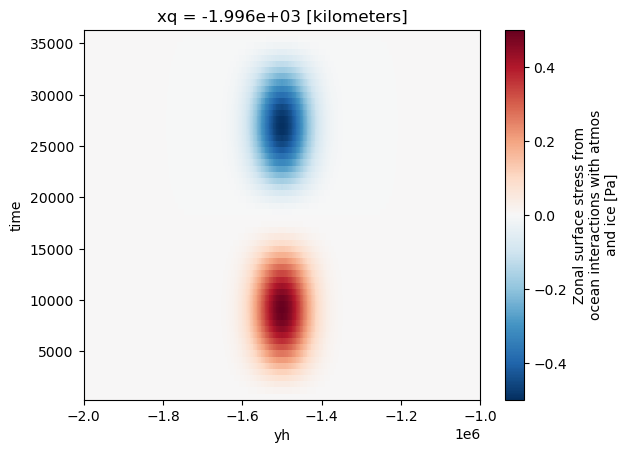

In [13]:
expt = todo[5]

path = expt.exptname + "/" + expt.runname

u =  xr.open_dataset(f"/home/149/ab8992/bottom_near_inertial_waves/juneruns/{path}/archive/output000/u_10min.nc",
decode_times = False,chunks = {"yh":100}).isel(zl = 0,xq = 2).u
tau = xr.open_dataset(f"/home/149/ab8992/bottom_near_inertial_waves/juneruns/{path}/archive/output000/taux_10min.nc",
decode_times = False,chunks = {"yh":100}).isel(xq = 2).taux

u = u.assign_coords({"time":("time",u.time.values * 60),
                        "yh":("yh",u.yh.values * 1000)
    })
tau = tau.assign_coords({"time":("time",tau.time.values * 60),
                        "yh":("yh",tau.yh.values * 1000)
    })

(tau).plot()

In [12]:
u

<xarray.DataArray 'u' (time: 60, yh: 500)>
dask.array<getitem, shape=(60, 500), dtype=float32, chunksize=(60, 100), chunktype=numpy.ndarray>
Coordinates:
    xq       float64 -1.996e+03
  * yh       (yh) float64 -1.999e+06 -1.997e+06 ... -1.003e+06 -1.001e+06
    zl       float64 1.025e+03
  * time     (time) float64 600.0 1.2e+03 1.8e+03 ... 3.48e+04 3.54e+04 3.6e+04
Attributes:
    long_name:      Zonal velocity
    units:          m s-1
    cell_methods:   zl:mean yh:mean xq:point time: point
    interp_method:  none

In [15]:
dim = "yh"
otherdim = "xh"
sliceint = 2
e = eslice = xr.open_mfdataset(
            f"/home/149/ab8992/bottom_near_inertial_waves/juneruns/{path}/archive/output00*/e_10min.nc",chunks = {"zi":1,dim:500},decode_times = False,parallel=True).isel({otherdim : sliceint,"time" : slice(0,4152//2)}).isel(zi = slice(1,5))

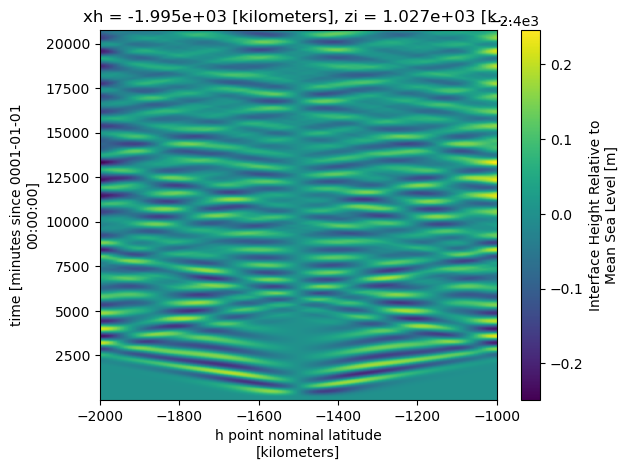

In [18]:
e.e.isel(zi = 2).plot()